#**Song Popularity Prediction**

In [ ]:
dataset_url = 'https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks'

In [ ]:
import os
os.listdir(data_dir)

['dict_artists.json',
 'artists.csv',
 'data_by_artists_o.csv',
 'data_by_year_o.csv',
 '.ipynb_checkpoints',
 'tracks.csv',
 'data_o.csv',
 'data_by_genres_o.csv']

In [ ]:
import pandas as pd

In [ ]:
tracks_df = pd.read_csv(data_dir + '/tracks.csv')
tracks_df

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4


## Exploratory Data Analysis and Visualization

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

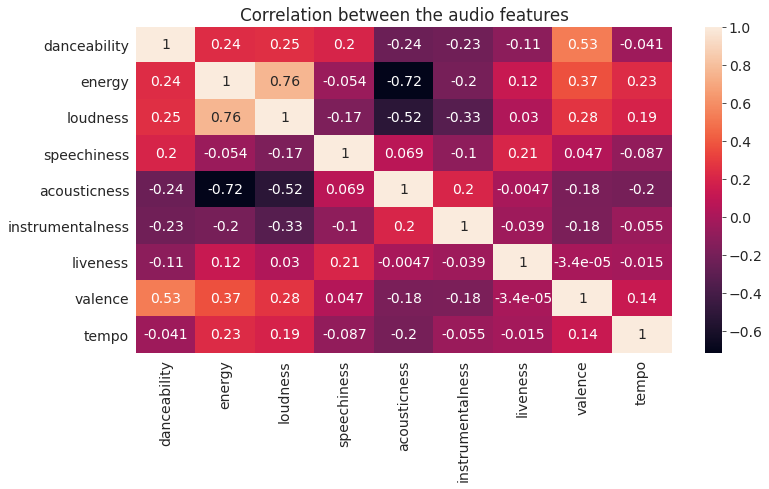

In [ ]:
corr = tracks_df[['danceability', 
                  'energy', 
                  'loudness', 
                  'speechiness', 
                  'acousticness', 
                  'instrumentalness', 
                  'liveness',
                  'valence', 
                  'tempo' ]].corr()

plt.title('Correlation between the audio features')
sns.heatmap(corr, annot=True);

In [ ]:
tracks_df.explicit.value_counts()

0    560808
1     25864
Name: explicit, dtype: int64

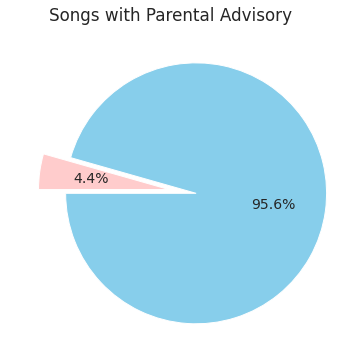

In [ ]:
plt.title('Songs with Parental Advisory')
plt.pie(tracks_df.explicit.value_counts(), 
        explode=(0.2, 0.01), 
        colors=['skyblue','#ffcccc'], 
        autopct='%1.1f%%', 
        startangle=180);

In [ ]:
px.scatter(tracks_df, x='release_date', y='popularity', title='Release Date vs. Popularity')

## Preprocessing




In [ ]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [ ]:
tracks_df['release_date'].sample(10)

280451          1954
318897    1994-01-01
467545    2003-01-01
570339          1954
38400     1964-01-01
367025    1996-08-09
567268    2000-12-18
305275    2020-05-15
65610     1992-01-01
392670    1982-01-01
Name: release_date, dtype: object

In [ ]:
def to_year(x):
    result = []
    x.to_string()
    for i in x:
        result.append(int(i[:4]))
    return result

tracks_df['year'] = to_year(tracks_df.release_date)

In [ ]:
tracks_df['year'].sample(10)

491215    1988
436448    2010
365012    1990
526481    2002
436743    2012
374357    2020
398975    2017
79429     2018
429506    1973
269191    1985
Name: year, dtype: int64

In [ ]:
max_year = tracks_df['year'].max()

In [ ]:
tracks_df['years_old'] = max_year - tracks_df['year']

In [ ]:
tracks_df['years_old'].sample(10)

560214     7
224465    34
563031    65
121726    86
92242      2
416956    63
297638    46
58044     37
418599    18
491004    37
Name: years_old, dtype: int64

In [ ]:
tracks_df['tempo'].value_counts()

0.000      328
128.003     98
119.994     91
139.980     89
127.994     86
          ... 
185.442      1
170.351      1
122.670      1
55.513       1
144.505      1
Name: tempo, Length: 122706, dtype: int64

In [ ]:
tracks_df.loc[tracks_df['tempo'] == 0 , 'tempo'] = tracks_df.loc[tracks_df['tempo'] > 0 , 'tempo'].mean()

In [ ]:
tracks_df['tempo'].value_counts()

118.531126    328
128.003000     98
119.994000     91
139.980000     89
127.994000     86
             ... 
185.442000      1
170.351000      1
122.670000      1
61.106000       1
144.505000      1
Name: tempo, Length: 122706, dtype: int64

In [ ]:
tracks_df['mean'] = tracks_df.groupby('artists')['popularity'].transform('mean')
tracks_df['count'] = tracks_df.groupby('artists')['popularity'].transform('count')

In [ ]:
def get_artist_popularity(x, y):
  result = y.groupby(x.artists).agg(['mean', 'count'])
  result.loc[result['count'] <= 2, 'mean'] = y.mean()
  result.loc[result['count'] >= 600, 'mean'] = 0
  return result

In [ ]:
temp_df = tracks_df.drop('popularity', axis=1)
result_df = get_artist_popularity(temp_df, tracks_df['popularity'])['mean']
tracks_df['artist_popularity'] = np.where(tracks_df['artists'].isin(result_df.index), 
                                          tracks_df['artists'], 
                                          'unknown')
tracks_df['artist_popularity'] = tracks_df['artist_popularity'].map(result_df)

In [ ]:
tracks_df[['artists', 'artist_popularity']].sample(10)

,artists,artist_popularity
37724,['Bob Dylan'],31.243070
308484,"['Cast of ""Folk Og Røvere I Kardemomme By""']",21.285714
73411,['Gustavo Cerati'],49.400000
200336,['Vicente Garcia'],45.041667
135171,"['The Victor Orchestra', 'Nat Shilkret']",0.031250
584631,"['Per Gessle', 'Helena Josefsson']",27.570053
501328,"['Johannes Brahms', 'Wilhelm Furtwängler', 'Wi...",0.000000
301688,"['Dr. Dre', 'Snoop Dogg']",64.714286
261596,['Hex'],16.733333
29816,"['Kishore Kumar', 'Asha Bhosle']",19.616162


### Input and Target Columns

In [ ]:
tracks_df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'year', 'years_old',
       'mean', 'count', 'artist_popularity'],
      dtype='object')

In [ ]:
input_columns = ['years_old', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 
                 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                 'liveness', 'valence', 'tempo', 'time_signature', 'artist_popularity']

target_column = 'popularity'

In [ ]:
numeric_cols = ['years_old', 'duration_ms', 'explicit', 'danceability', 'energy', 
                'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'artist_popularity']
categorical_cols = ['key', 'time_signature']

In [ ]:
tracks_df['key'].value_counts()

0     74950
7     73779
2     66552
9     65128
5     53614
4     48220
1     41736
11    39132
10    37710
8     33460
6     30856
3     21535
Name: key, dtype: int64

In [ ]:
tracks_df['time_signature'].value_counts()

4    503808
3     64523
5     11400
1      6604
0       337
Name: time_signature, dtype: int64

### Training, Validation and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_val_df, test_df = train_test_split(tracks_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [ ]:
print('train_df', train_df.shape)
print('val_df', val_df.shape)
print('test_df', test_df.shape)

train_df (352002, 25)
val_df (117335, 25)
test_df (117335, 25)


In [ ]:
train_inputs = train_df[input_columns].copy()
val_inputs = val_df[input_columns].copy()
test_inputs = test_df[input_columns].copy()

In [ ]:
Y_train = train_df[target_column].copy()
Y_val = val_df[target_column].copy()
Y_test = test_df[target_column].copy()

### Imputing missing values

In [ ]:
tracks_df[input_columns].isna().sum()

years_old            0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
artist_popularity    0
dtype: int64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler().fit(tracks_df[numeric_cols])

In [ ]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [ ]:
Y_train = Y_train / 100
Y_val = Y_val / 100
Y_test = Y_test / 100

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(tracks_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [ ]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Linear Regression



In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
linear_model = Ridge()

In [ ]:
linear_model.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
linear_train_predictions = linear_model.predict(X_train)

In [ ]:
linear_train_predictions

array([0.2382466 , 0.33454942, 0.56792125, ..., 0.04601526, 0.46541006,
       0.37539489])

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
train_rmse = mean_squared_error(linear_train_predictions, Y_train, squared=False)

In [ ]:
print('The RMSE loss for training set is ', train_rmse)

The RMSE loss for training set is  0.11869256238860909


In [ ]:
linear_val_predictions = linear_model.predict(X_val)
val_rmse = mean_squared_error(linear_val_predictions, Y_val, squared=False)
print('The RMSE loss for validation set is ', val_rmse)

The RMSE loss for validation set is  0.11880934110046901


In [ ]:
linear_test_predictions = linear_model.predict(X_test)
test_rmse = mean_squared_error(linear_test_predictions, Y_test, squared=False)
print('The RMSE loss for test set is ', test_rmse)

The RMSE loss for test set is  0.11783782221260501


## Random Forest



In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
random_forest_model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
random_forest_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
random_forest_train_preds = random_forest_model.predict(X_train)
random_forest_train_preds

array([0.2692 , 0.2128 , 0.4946 , ..., 0.0655 , 0.423  , 0.37572])

In [ ]:
train_rmse = mean_squared_error(random_forest_train_preds, Y_train, squared=False)
print('The RMSE loss for training set is ', train_rmse)

The RMSE loss for training set is  0.03816131456756738


In [ ]:
random_forest_val_preds = random_forest_model.predict(X_val)
random_forest_val_preds

array([3.0130e-02, 3.4100e-02, 5.6460e-01, ..., 5.7665e-01, 4.3920e-01,
       3.0000e-04])

In [ ]:
val_rmse = mean_squared_error(random_forest_val_preds, Y_val, squared=False)
print('The RMSE loss for validation set is ', val_rmse)

The RMSE loss for validation set is  0.0985493109542275


In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, Y_train)
    train_rmse = mean_squared_error(model.predict(X_train), Y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), Y_val, squared=False)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

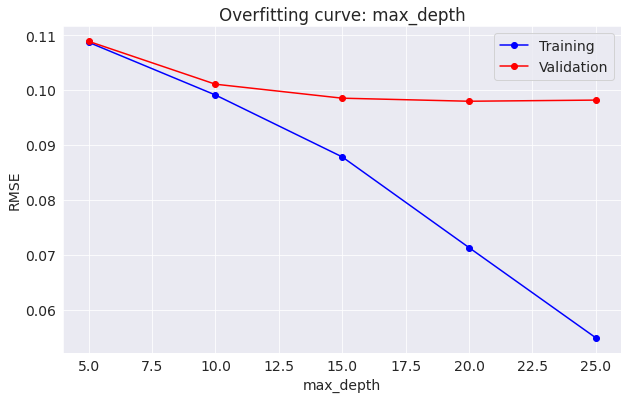

In [ ]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25])

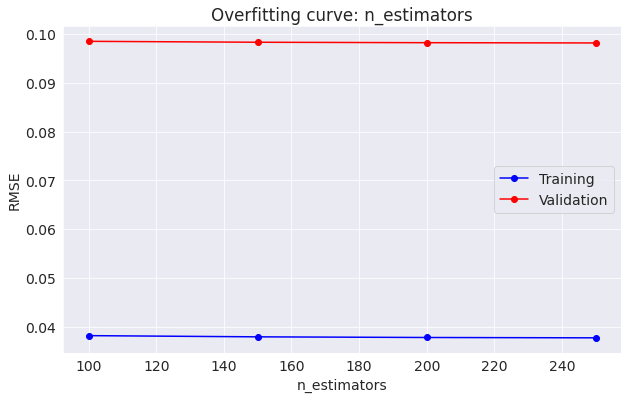

In [ ]:
test_param_and_plot('n_estimators', [100, 150, 200, 250])

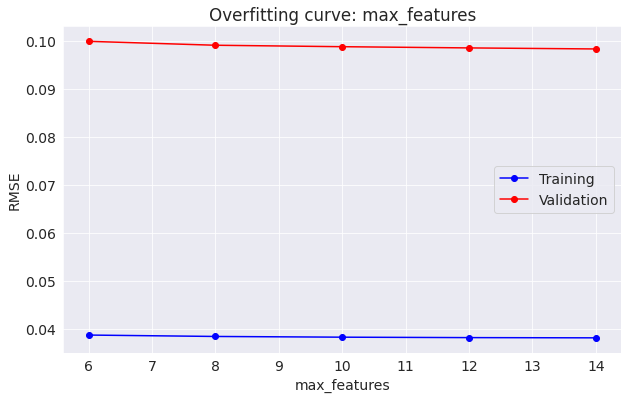

In [ ]:
test_param_and_plot('max_features', [6, 8, 10, 12, 14])

In [ ]:
random_forest_model = RandomForestRegressor(n_jobs=-1, 
                                            random_state=42, 
                                            max_depth=15, 
                                            n_estimators=100, 
                                            max_features=10)
random_forest_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
train_acc = random_forest_model.score(X_train, Y_train)
train_rmse = mean_squared_error(random_forest_model.predict(X_train), Y_train, squared=False)
print('The RMSE loss for training set is ', train_rmse, ' and accuracy is ', train_acc*100, '%')

The RMSE loss for training set is  0.08949642866541821  and accuracy is  76.32310537376918 %


In [ ]:
val_acc = random_forest_model.score(X_val, Y_val)
val_rmse = mean_squared_error(random_forest_model.predict(X_val), Y_val, squared=False)
print('The RMSE loss for validation set is ', val_rmse, ' and accuracy is ', val_acc*100, '%')

The RMSE loss for validation set is  0.09923756195532543  and accuracy is  70.85634588193562 %


In [ ]:
test_acc = random_forest_model.score(X_test, Y_test)
test_rmse = mean_squared_error(random_forest_model.predict(X_test), Y_test, squared=False)
print('The RMSE loss for test set is ', test_rmse, ' and accuracy is ', test_acc*100, '%')

The RMSE loss for test set is  0.09848852947939368  and accuracy is  71.01177622937989 %


In [ ]:
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': random_forest_model.feature_importances_
}).sort_values('importance', ascending=False)

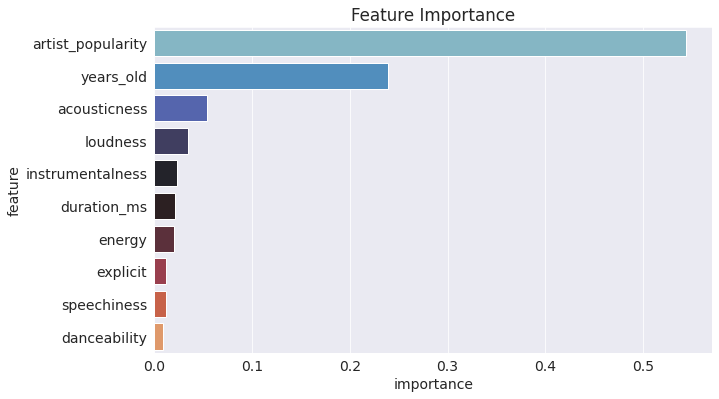

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='icefire');

In [ ]:
!pip install xgboost --upgrade --quiet

In [ ]:
from xgboost import XGBRegressor

In [ ]:
gbm_model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [ ]:
gbm_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
gbm_train_preds = gbm_model.predict(X_train)
gbm_train_preds

array([0.22382605, 0.35105187, 0.5886918 , ..., 0.02703674, 0.4237026 ,
       0.36623526], dtype=float32)

In [ ]:
train_rmse = mean_squared_error(gbm_train_preds, Y_train, squared=False)
print('The RMSE loss for training set is ', train_rmse)

The RMSE loss for training set is  0.1030407038841221


In [ ]:
gbm_val_preds = gbm_model.predict(X_val)
gbm_val_preds

array([0.03452813, 0.0514764 , 0.47231337, ..., 0.4423982 , 0.4675226 ,
       0.01998455], dtype=float32)

In [ ]:
val_rmse = mean_squared_error(gbm_val_preds, Y_val, squared=False)
print('The RMSE loss for validation set is ', val_rmse)

The RMSE loss for validation set is  0.10338607422749921


In [ ]:
def test_params(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, Y_train)
    train_rmse = mean_squared_error(model.predict(X_train), Y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val), Y_val, squared=False)
    return train_rmse, val_rmse

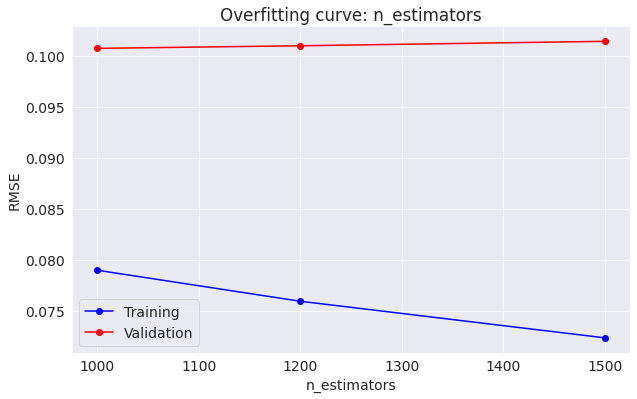

In [ ]:
test_param_and_plot('n_estimators', [1000, 1200, 1500])

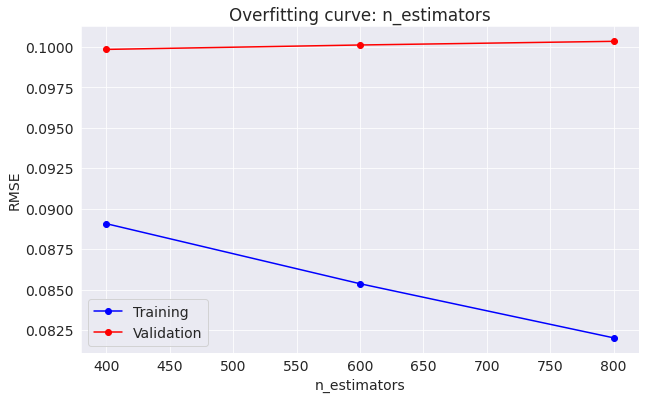

In [ ]:
test_param_and_plot('n_estimators', [400, 600, 800])

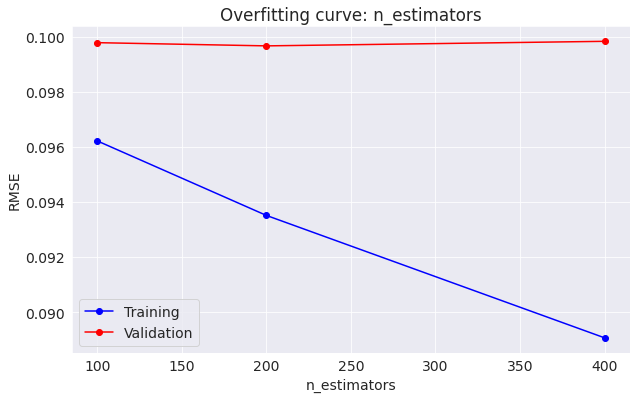

In [ ]:
test_param_and_plot('n_estimators', [100, 200, 400])

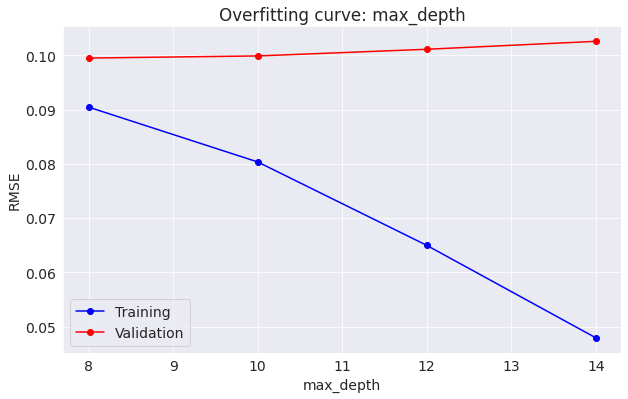

In [ ]:
test_param_and_plot('max_depth', [8, 10, 12, 14])

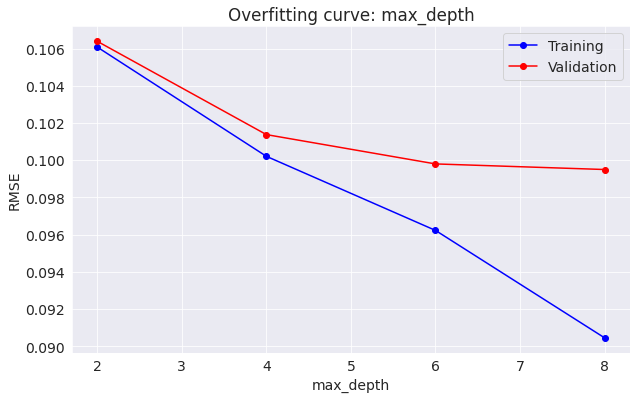

In [ ]:
test_param_and_plot('max_depth', [2, 4, 6, 8])

In [ ]:
def test_and_plot_learning_rate(param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {'learning_rate': value, 'n_estimators': 200}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + 'learning_rate')
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel('learning_rate')
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

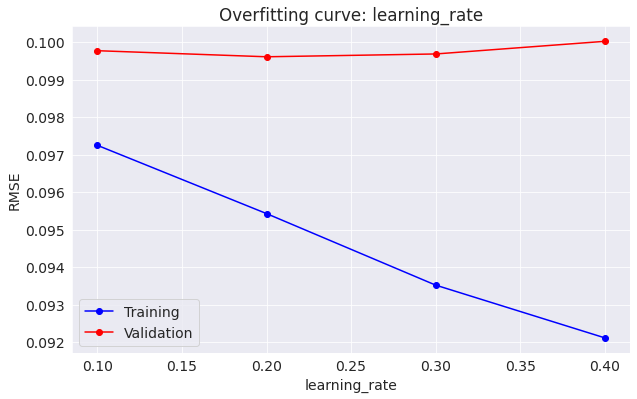

In [ ]:
test_and_plot_learning_rate([0.1, 0.2, 0.3, 0.4])

In [ ]:
gbm_model = XGBRegressor(random_state=42, 
                         n_jobs=-1, 
                         n_estimators=200, 
                         max_depth=8, 
                         learning_rate=0.2)
gbm_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
train_acc = gbm_model.score(X_train, Y_train)
train_rmse = mean_squared_error(gbm_model.predict(X_train), Y_train, squared=False)
print('The RMSE loss for training set is ', train_rmse, ' and accuracy is ', train_acc*100, '%')

The RMSE loss for training set is  0.0881456457592302  and accuracy is  77.03242948569432 %


In [ ]:
val_acc = gbm_model.score(X_val, Y_val)
val_rmse = mean_squared_error(gbm_model.predict(X_val), Y_val, squared=False)
print('The RMSE loss for validation set is ', val_rmse, ' and accuracy is ', val_acc*100, '%')

The RMSE loss for validation set is  0.09907624298519543  and accuracy is  70.95101977146088 %


In [ ]:
test_acc = gbm_model.score(X_test, Y_test)
test_rmse = mean_squared_error(gbm_model.predict(X_test), Y_test, squared=False)
print('The RMSE loss for test set is ', test_rmse, ' and accuracy is ', test_acc*100, '%')

The RMSE loss for test set is  0.09836366440351287  and accuracy is  71.08523295130684 %


In [ ]:
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gbm_model.feature_importances_
}).sort_values('importance', ascending=False)

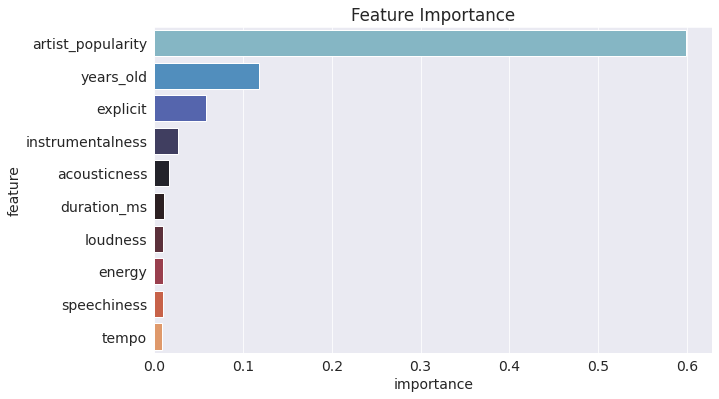

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='icefire');

## Making Predictions

Now let's make predictions on a single input.

In [ ]:
new_input = {
    'name' : 'Watermelon Sugar',
    'duration_ms' : 174000,
    'explicit' : 0,
    'artists'	: "['Harry Styles']",
    'release_date' : '2019',
    'danceability' : 0.548,
    'energy' : 0.816,
    'key' : 0,
    'loudness' : -4.209,
    'mode' : 1,
    'speechiness' : 0.0465,
    'acousticness' : 0.122,
    'instrumentalness' : 0.0,
    'liveness' : 0.335,
    'valence' : 0.557,
    'tempo' : 95.39,
    'time_signature' : 4
}

Let's declare the variables that we will need for preprocessing.

In [ ]:
max_year = tracks_df['year'].max()
mean_tempo = tracks_df.loc[tracks_df['tempo'] > 0 , 'tempo'].mean()

In [ ]:
def predict_input(model, single_input):
  input_df = pd.DataFrame([single_input])

  #Year
  input_df['year'] = to_year(input_df.release_date)
  input_df['years_old'] = max_year - input_df['year']

  #Tempo
  if input_df.tempo[0] == 0:
    input_df['tempo'] = mean_tempo
  
  #Artists
  flag = False
  for index in tracks_df.index:
    if tracks_df.loc[index]['artists'] == input_df.artists[0]:
      flag = True
      input_df['artist_popularity'] = tracks_df.loc[index]['artist_popularity']
      break
  
  if(flag == False):
    input_df['artist_popularity'] = tracks_df['popularity'].mean()

  #scaling and Encoding
  input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
  X_input = input_df[numeric_cols + encoded_cols]

  pred = model.predict(X_input)[0]
  pred = pred * 100
  return pred

In [ ]:
print('Predicted popularity of the song is ', predict_input(gbm_model, new_input))

Predicted popularity of the song is  76.92539095878601
